In [154]:

!pip install xgboost

     ---------------------------------------- 89.1/89.1 MB 3.7 MB/s eta 0:00:00


## Importing Packages and Datasets 

In [10]:
import os 
import pandas as pd 
from pandas.plotting import autocorrelation_plot
from pandas import to_datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import math 

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
from pmdarima.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model



In [3]:
hist_gun_vio = pd.read_csv('C:/Users/justd/Desktop/IPI - PRSA/Gun_Violence/all_incidents.csv',header=0)


new_cols = hist_gun_vio['date'].str.split('/', expand=True)

hist_gun_vio['year'] = new_cols[2]
hist_gun_vio['month'] = new_cols[0]
hist_gun_vio['day'] = new_cols[1]

new_cols
hist_gun_vio

#hist_gun_vio.to_csv('C:/Users/justd/Desktop/IPI - PRSA/Gun_Violence/all_incidents_revised.csv', index=False)

,incident_id,date,state,city,address,n_killed,n_injured,year,month,day
0,2314858,5/28/2022,Arkansas,Little Rock,W 9th St and Broadway St,0,1,2022,5,28
1,2314409,5/28/2022,Colorado,Denver,3300 block of Clay St,0,1,2022,5,28
2,2314498,5/28/2022,Missouri,Saint Louis,Page Blvd and Vandeventer Ave,0,1,2022,5,28
3,2314485,5/28/2022,South Carolina,Florence,Old River Rd,0,2,2022,5,28
4,2314483,5/28/2022,California,Carmichael,4400 block of Manzanita Ave,1,0,2022,5,28
...,...,...,...,...,...,...,...,...,...,...
246940,1018982,1/1/2018,New Jersey,Sicklerville,Sherri Ln,0,2,2018,1,1
246941,1018185,1/1/2018,Washington,Pasco,1505 S Rd 40 E,0,0,2018,1,1
246942,1018182,1/1/2018,North Carolina,Charlotte,1800 Block of S Tryon St,0,1,2018,1,1
246943,1019027,1/1/2018,Florida,Gainesville,Waldo Rd,0,0,2018,1,1


## Forecasting Time Series

DatetimeIndex(['2018-01-01', '2018-01-01', '2018-01-01', '2018-01-01',
               '2018-01-01', '2018-01-01', '2018-01-01', '2018-01-01',
               '2018-01-01', '2018-01-01',
               ...
               '2021-09-09', '2021-09-09', '2021-09-09', '2021-09-09',
               '2021-09-09', '2021-09-09', '2021-09-09', '2021-09-09',
               '2021-09-09', '2021-09-09'],
              dtype='datetime64[ns]', name='date', length=246945, freq=None)

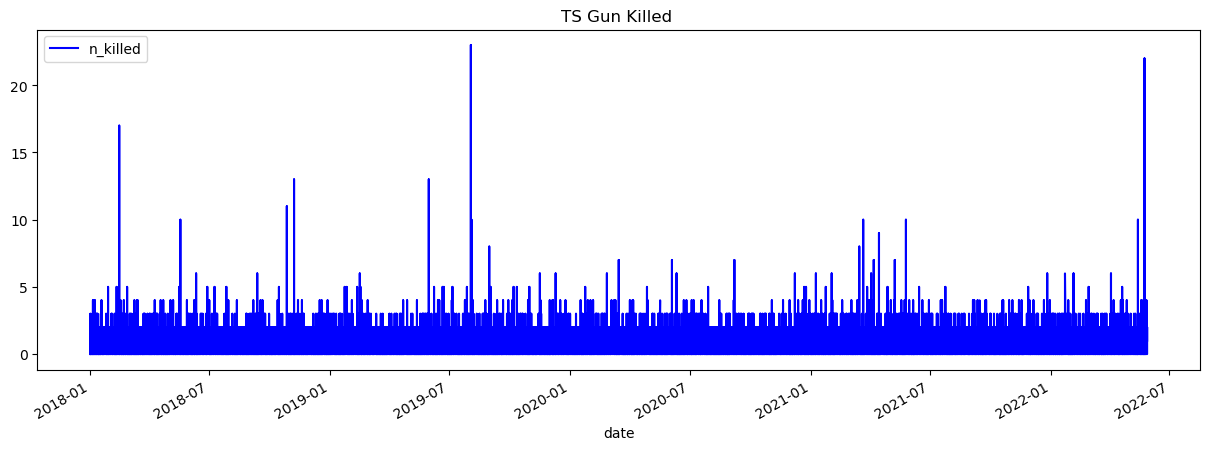

In [4]:
hist_gun_vio_v1 = hist_gun_vio[['date','n_killed']]
hist_gun_vio_v1 = hist_gun_vio_v1.set_index('date')
hist_gun_vio_v1 = hist_gun_vio_v1.sort_values(by='date', ascending=True)
hist_gun_vio_v1.index = pd.to_datetime(hist_gun_vio_v1.index)

hist_gun_vio_v1.plot(style='-', figsize=(15,5), color='blue', title='TS Gun Killed ')

hist_gun_vio_v1.index


#Time series Function plotting 
#def plot_ds(df, x, y, title="", xlabel='Date',ylabel='Val', dpi=100): 
    #plt.figure(figsize=(20,10), dpi=dpi) 
    #plt.plot(x, y, color='tab:red') 
    #plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel) 
    #plt.show()

#plot_ds(hist_gun_vio_1, x=hist_gun_vio.year, y=hist_gun_vio.n_killed, title='Annual Gun Violence Kills by County')


#### 1. Preproc. & Test/Train Data

In [5]:
hist_gun_vio2 = hist_gun_vio[['date','state','city','n_killed']]

hist_gun_vio2['date'] = pd.to_datetime(hist_gun_vio2['date'])

hist_gun_vio2 = hist_gun_vio2.sort_values(by='date', ascending=True)

hist_gun_vio2

#checks for null values 
#hist_gun_vio2.isnull().sum()



#Incase we need to delete the null rows 
#hist_gun_vio2 = hist_gun_vio2.dropna(subset = ['values'])

C:\Users\justd\AppData\Local\Temp\ipykernel_11508\3331938863.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_gun_vio2['date'] = pd.to_datetime(hist_gun_vio2['date'])


,date,state,city,n_killed
246944,2018-01-01,Ohio,Cleveland,0
246789,2018-01-01,Massachusetts,Boston,0
246788,2018-01-01,California,Oakland,1
246787,2018-01-01,New York,Buffalo,0
246786,2018-01-01,California,Auburn,0
...,...,...,...,...
28,2022-05-28,Indiana,Evansville,0
27,2022-05-28,Virginia,Chesapeake,0
26,2022-05-28,Texas,Fort Worth,0
36,2022-05-28,New York,Brooklyn,0


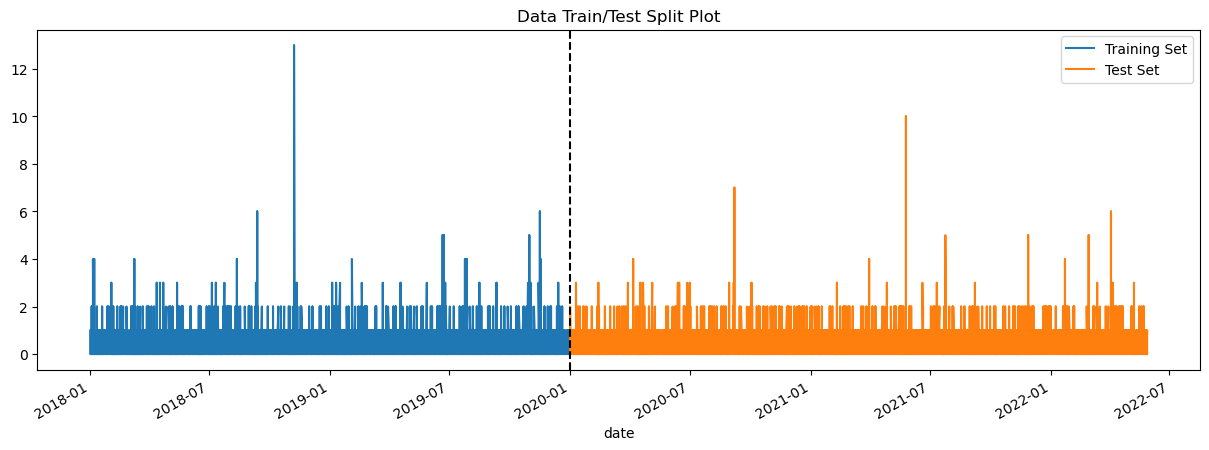

In [44]:
train = hist_gun_vio2[hist_gun_vio2['date'] < '2020-01-01']
test = hist_gun_vio2[hist_gun_vio2['date'] >= '2020-01-01']


#filters only for California training set
cali_train = train[train['state'] == 'California']
#reduces set to just date and n killed
cali_train2 = cali_train[['date','n_killed']]

#filters only for california validation set
cali_test = test[test['state'] == 'California']
#reduces set to date and n killed
cali_test2 = cali_test[['date','n_killed']]

#Indexing the dataframe
cali_train2.set_index('date', inplace=True)
cali_test2.set_index('date', inplace=True)


#Plotting the train/test split data
fig, ax = plt.subplots(figsize=(15,5))
cali_train2.plot(ax=ax, label='Training Set', title='Data Train/Test Split Plot')
cali_test2.plot(ax=ax, label='Test Set')
ax.axvline('2020-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()
        
#print(x_train.shape)
#print(x_test.shape)
#cali_train['date'].unique()

#### 2. Feature Engineering

,date,state,city,n_killed,dayofweek,quarter,month,year,dayofyear
246925,2022-05-28,Illinois,Chicago,1,5,2,5,2022,148
246926,2022-05-28,Arkansas,Little Rock,1,5,2,5,2022,148
246927,2022-05-28,Oregon,Gresham,0,5,2,5,2022,148
246928,2022-05-28,West Virginia,Putnam (county),1,5,2,5,2022,148
246929,2022-05-28,California,North Hollywood,0,5,2,5,2022,148
246930,2022-05-28,Arizona,Phoenix,2,5,2,5,2022,148
246931,2022-05-28,Louisiana,New Orleans,1,5,2,5,2022,148
246932,2022-05-28,North Carolina,Sanford,1,5,2,5,2022,148
246933,2022-05-28,New York,Corona (Queens),0,5,2,5,2022,148
246934,2022-05-28,New York,New York (Manhattan),0,5,2,5,2022,148


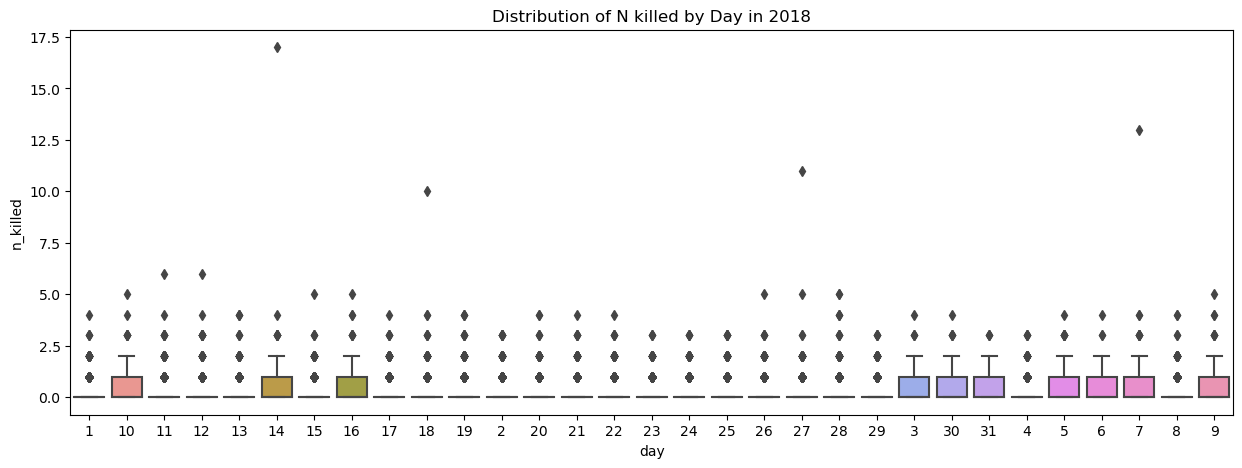

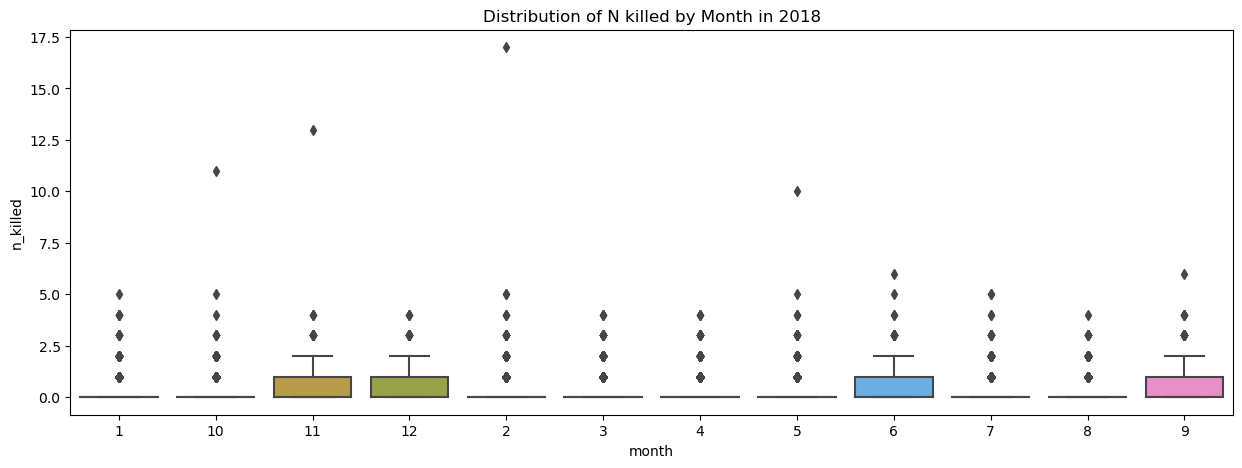

In [6]:
def create_feat(df):

    df = df.copy()
    df = df.set_index('date')
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df1 = create_feat(hist_gun_vio2)

hist_gun_vio2018 = hist_gun_vio[hist_gun_vio['year'] == '2018']
hist_gun_vio2018v2 = hist_gun_vio2018[['date', 'n_killed', 'year', 'month', 'day']]
hist_gun_vio2018v2.set_index('date', inplace=True)
hist_gun_vio2018v2 = hist_gun_vio2018v2.sort_values(by='date', ascending= True)



fig, ax = plt.subplots(figsize=(15,5))
sn.boxplot(data=hist_gun_vio2018v2, x='day', y='n_killed')
ax.set_title('Distribution of N killed by Day in 2018')


fig, ax = plt.subplots(figsize=(15,5))
sn.boxplot(data=hist_gun_vio2018v2, x='month', y='n_killed')
ax.set_title('Distribution of N killed by Month in 2018')

df1 = df1.reset_index()

df1.tail(20)

#### 3. ARMA Model Building

In [38]:
#Finding best model score

for i in range(0,2):
    for j in range(0,2):
        for k in range(0,2):
            ARMAmodel = SARIMAX(cali_train2, order = (1, 1, 1))
            ARMAmodel = ARMAmodel.fit()
            print(ARMAmodel.aic)





D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


19198.66146131652


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


19198.66146131652


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


19198.66146131652


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


19198.66146131652


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


19198.66146131652


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


19198.66146131652


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


19198.66146131652


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


19198.66146131652


In [ ]:
y_pred = ARMAmodel.get_forecast(len(cali_test2.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df['Predictions'] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = cali_test2.index
y_pred_out = y_pred_df['Predictions']

plt.plot(y_pred_out, color='green', label = 'predictions')
plt.xticks(rotation=90)

# Multi-Variate Logistic Regression

#### 1. Preprocessing Data & Classification 